# Lesson 08 - Redes Neurais Convolucionais

Luís Guilherme Gaboardi Lins

180022962

## Objetivo
Este artigo tem como objetivo analisar o funcionamento de uma CNN (Rede Neural Convolucional) na diferenciação entre taças de vinho e copos, usando imagens do DuckDuckGo. Posteriormente esse modelo é colocado no Hugging Face para testes.

## 1. Instalando e importando os requisitos

In [18]:
# Instalando
!pip install -qqq fastai duckduckgo_search torch

In [6]:
# Importando
from fastcore.all import *
from fastai.vision.all import *
from fastdownload import download_url
from duckduckgo_search import ddg_images
from time import sleep
from PIL import Image
import numpy as np

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 2. Recuperando os dados

In [7]:
# Definição da função de busca no Duck Duck Go
def search_images(term, max_images=300):
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

/opt/conda/lib/python3.10/site-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


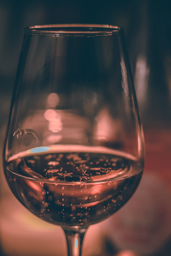

In [8]:
# Exemplo de taça de vinho
vinho = search_images('empty wine glass', max_images=1)[0]
download_url(vinho, 'vinho.jpg', show_progress=False)

Image.open('vinho.jpg').to_thumb(256, 256)

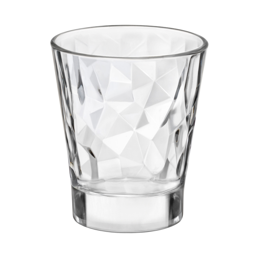

In [9]:
# Exemplo de taça de espumante
copo = search_images('glass cup', max_images=1)[0]
download_url(copo, 'copo.jpg', show_progress=False)

Image.open('copo.jpg').to_thumb(256, 256)

Tendo como referência os exemplos acima, vamos baixar mais exemplos e usar como a nossa base de dados

In [10]:
searchs = 'empty wine glass', 'glass cup'
path = Path('glasses')

for glass in searchs:
    dest = (path/glass)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{glass}'))
    sleep(1)
    resize_images(path/glass, max_size=400, dest=path/glass)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [11]:
# Remove imagens cujo download não foi bem sucecido
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

8

## 3. Como funciona uma rede neural convolucional


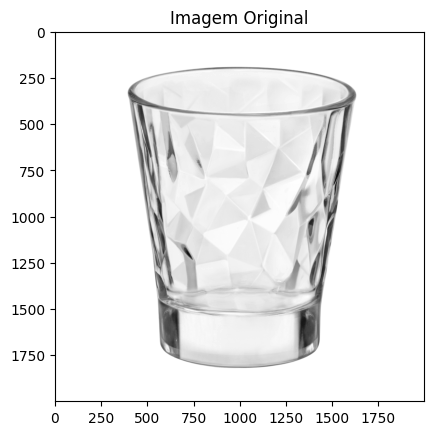

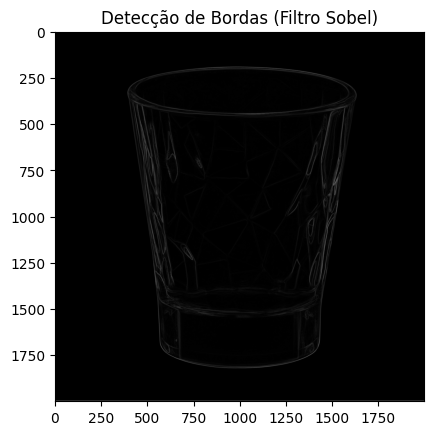

In [33]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

imagem_path = 'copo.jpg'
imagem = Image.open(imagem_path).convert('L')  # Converta para escala de cinza
plt.imshow(imagem, cmap='gray')
plt.title('Imagem Original')
plt.show()

# Converte a imagem para um tensor
imagem_tensor = torch.tensor(np.array(imagem) / 255.0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Define o filtro de Sobel para detecção de bordas
filtro_sobel_x = torch.tensor([[-1, 0, 1],
                               [-2, 0, 2],
                               [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

filtro_sobel_y = torch.tensor([[-1, -2, -1],
                               [0, 0, 0],
                               [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)

# Aplica a convolução para detectar bordas nas direções x e y
resultado_x = F.conv2d(imagem_tensor, filtro_sobel_x, stride=1, padding=1)
resultado_y = F.conv2d(imagem_tensor, filtro_sobel_y, stride=1, padding=1)

# Combina os resultados para obter uma imagem de bordas
resultado_final = torch.sqrt(resultado_x**2 + resultado_y**2)

# Exiba a imagem resultante
plt.imshow(resultado_final.squeeze().numpy(), cmap='gray')
plt.title('Detecção de Bordas (Filtro Sobel)')
plt.show()

## 4. Conversão dos dados para DataBlocks e DataLoaders

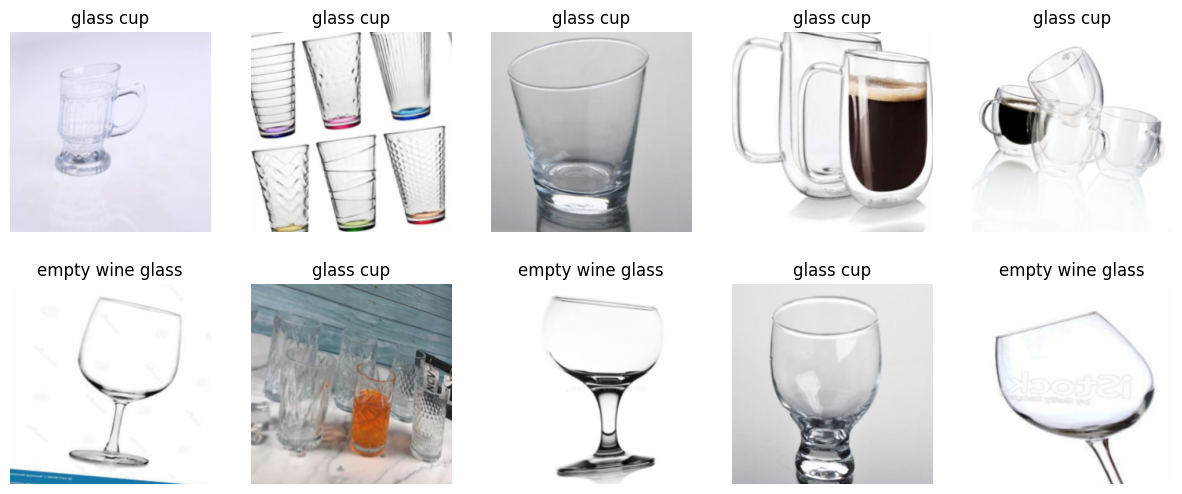

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=37),
    get_y=parent_label,
    item_tfms=[Resize(256, method='squish')],
    batch_tfms=aug_transforms(mult=1.0, do_flip=True, flip_vert=False, max_rotate=10.0, min_zoom=1.0, max_zoom=1.1, max_lighting=0.2, p_affine=0.75, p_lighting=0.75, xtra_tfms=None, size=None, mode='bilinear', pad_mode='reflection', align_corners=True, batch=False, min_scale=1.0)
).dataloaders(path, bs=32)

dls.show_batch(max_n=10, nrows=2)

## 5. Treinando o Modelo

In [15]:
learn = vision_learner(dls, resnet34, metrics=accuracy)
learn.fine_tune(2)

epoch,train_loss,valid_loss,accuracy,time
0,0.971985,0.214642,0.909091,00:01


epoch,train_loss,valid_loss,accuracy,time
0,0.206386,0.147748,0.939394,00:01
1,0.120218,0.138814,0.939394,00:01


## 6. Testando nos exemplos

In [16]:
# Taça de vinho
is_vinho, _, probs = learn.predict(PILImage.create('vinho.jpg'))
print(f"{is_vinho}.")
print(f"Probabilidade: {1 - probs[1]:.4f}")

empty wine glass.
Probabilidade: 0.9992


In [17]:
# Taça de espumante
is_copo, _, probs = learn.predict(PILImage.create('copo.jpg'))
print(f"{is_copo}.")
print(f"Probabilidade: {probs[1]:.4f}")

glass cup.
Probabilidade: 0.9995


## 6. Deploy no Hugging Face

O modelo está disponível para teste no link: [https://huggingface.co/spaces/luisgaboardi/FastAI-Lesson8-Convolutional/tree/main](https://huggingface.co/spaces/luisgaboardi/FastAI-Lesson8-Convolutional/tree/main)

In [34]:
learn.export('model.pkl')